In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

# from test_utils import summary, comparator

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''

image_path = os.path.join(path, '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/')
mask_path = os.path.join(path, '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/')

print(image_path)
print(mask_path)

image_list = os.listdir(image_path)
image_list = [image_path+i for i in image_list]
print(image_list)

mask_list = os.listdir(mask_path)
mask_list = [mask_path+i for i in mask_list]
print(mask_list)

/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/
/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/
['/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00003.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00001.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00006.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00004.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00002.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00005.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00010.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00008.png', '/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00009.png', '/content/drive/MyDrive/Deep learning/CNN/Ima

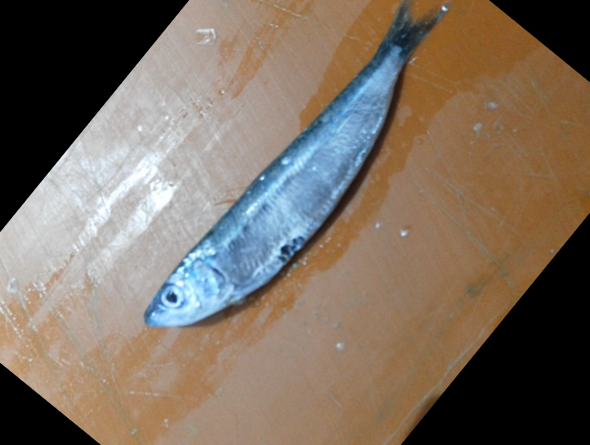

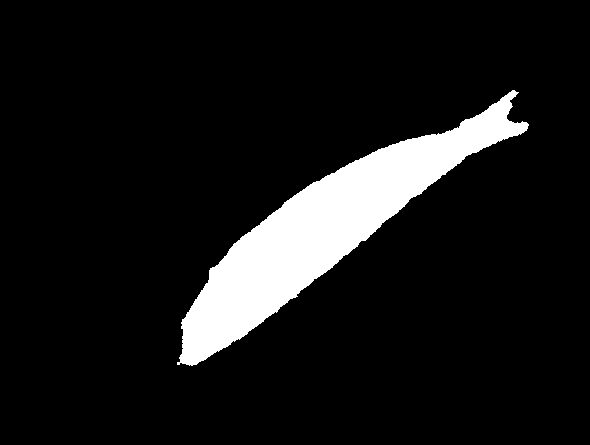

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

# fig, arr = plt.subplots(1, 2, figsize=(14, 10))
# arr[0].imshow(img)
# arr[0].set_title('Image')
# arr[1].imshow(mask[:, :, 0])
# arr[1].set_title('Segmentation')

import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(mask)

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

print(image_list_ds)
print(mask_list_ds)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/00001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/00002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/00003.png'>)


In [8]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# print(image_filenames)
# print("**")
# print(masks_filenames)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/image/00003.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Deep learning/CNN/Image Segmentation/Fish_test/mask/00002.png', shape=(), dtype=string)


In [15]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

# ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 96, 128, 3)

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [29]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model


unet=simple_unet_model(128,128,3)

unet.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [30]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(445, 590, 1)


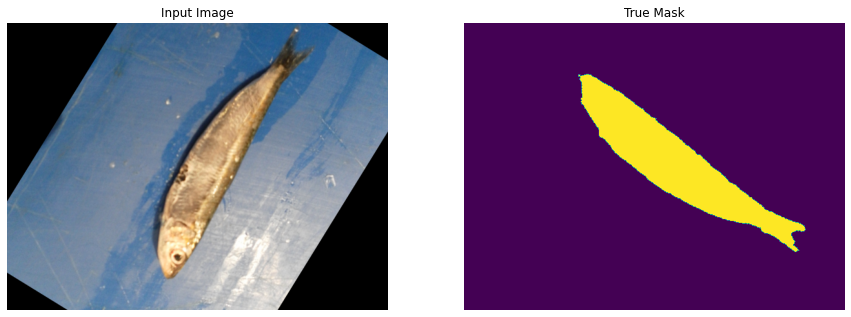

In [31]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(128, 128, 1)


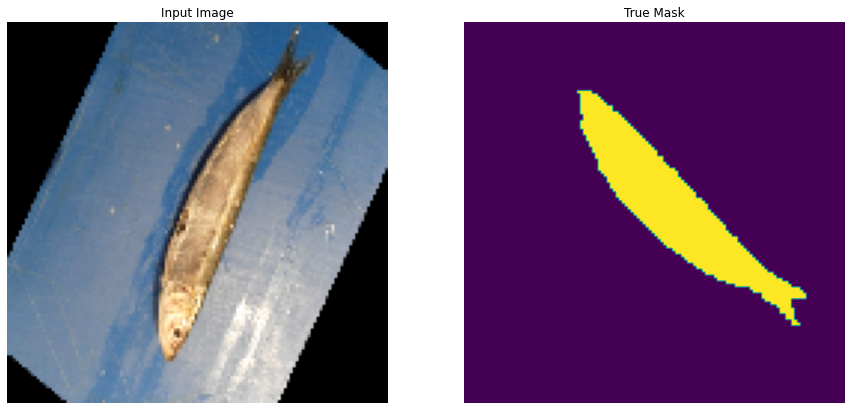

In [32]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [33]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: -17.0441 - accuracy: 0.1659
Epoch 2/40
1/1 [==============================] - 2s 2s/step - loss: -77.9165 - accuracy: 0.0821
Epoch 3/40
1/1 [==============================] - 2s 2s/step - loss: -960.2570 - accuracy: 0.0471
Epoch 4/40
1/1 [==============================] - 4s 4s/step - loss: -10513.9453 - accuracy: 0.0163
Epoch 5/40
1/1 [==============================] - 2s 2s/step - loss: -87117.6797 - accuracy: 0.0049
Epoch 6/40
1/1 [==============================] - 2s 2s/step - loss: -595440.4375 - accuracy: 0.0014
Epoch 7/40
1/1 [==============================] - 2s 2s/step - loss: -3487962.0000 - accuracy: 6.2256e-04
Epoch 8/40
1/1 [==============================] - 2s 2s/step - loss: -18283680.0000 - accuracy: 2.6855e-04
Epoch 9/40
1/1 [==============================] - 2s 2s/step - loss: -8

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

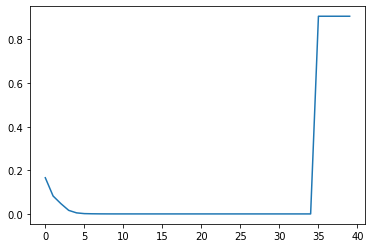

In [35]:
plt.plot(model_history.history["accuracy"])

In [36]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [39]:
# show_predictions(train_dataset, 6)